# Image Generation
* Digital Artists?
* Creativity?
* Diffusion models
  - Dall-E
* Generative adversarial networks (GANs)
  - Proposed by Ian Goodfellow in 2014

## Transposed Convolution

How to reverse a convolution operation. In words how do I upsample?

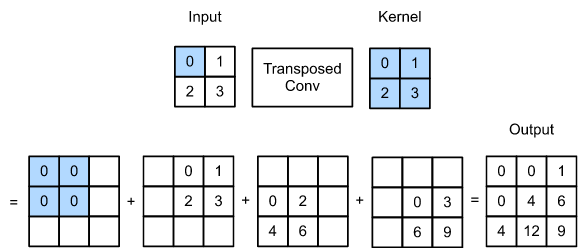

![ChessUrl](https://miro.medium.com/v2/resize:fit:720/1*kOThnLR8Fge_AJcHrkR3dg.gif "chess")


## Exercises
* Write a function SimpleTransposeConv2D that will take two matrices named "image" and "kernel" of shape (2,2) and (2,2) respectively and will return an output matrix after applying the Transposed Convolution operation

In [ ]:
import numpy as np


In [ ]:
def my_transpose_conv2d(image,kernel):
# Write your code here


# GANs

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Download the dataset

In [ ]:
!gdown "1FVsgkLcrVSa_8w5feFm8EAiT3tdBksMF&confirm=t"
!unzip -q '/content/archive.zip'

Downloading...
From: https://drive.google.com/uc?id=1FVsgkLcrVSa_8w5feFm8EAiT3tdBksMF&confirm=t
To: /content/archive.zip
100% 101M/101M [00:00<00:00, 116MB/s] 


In [ ]:
DATA_DIR = '/content/cats'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

## Training

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

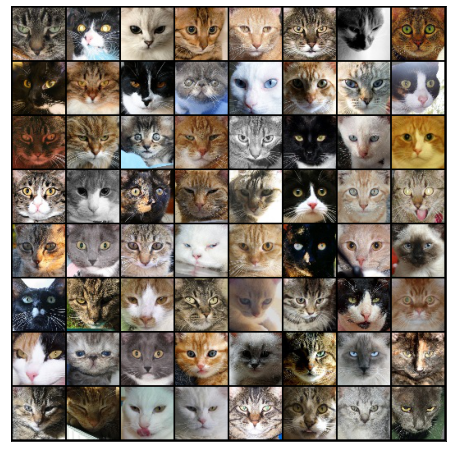

In [ ]:
show_batch(train_dl)



In [ ]:
latent_size =128
device = 'cuda'
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)


lr = 0.0002
epochs = 60





In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)
generator = generator.to(device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
discriminator = discriminator.to(device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # fake_images = fake_images.to(device)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 3.0269, loss_d: 0.8415, real_score: 0.6950, fake_score: 0.3385
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 5.5287, loss_d: 0.9929, real_score: 0.7475, fake_score: 0.4622
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
torch.save(generator.state_dict(), '/content/generator.pth')

## Load training results

In [ ]:
# !gdown "1_20VN3EyJgI8geuHR0boqtV0lg77i24R&confirm=t"
!gdown "1sMsDjKJJAoGhQvTuXbqOrmZ20bXn3D6h&confirm=t"
!gdown "1pO19H1k47dDacPvPno0aFQBAJ9_12kVM&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1sMsDjKJJAoGhQvTuXbqOrmZ20bXn3D6h&confirm=t
To: /content/generated.zip
100% 37.3M/37.3M [00:02<00:00, 12.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pO19H1k47dDacPvPno0aFQBAJ9_12kVM&confirm=t
To: /content/generator(1).pth
100% 15.2M/15.2M [00:01<00:00, 10.5MB/s]


In [ ]:
generator.load_state_dict(torch.load('/content/generator(1).pth'))

<All keys matched successfully>

In [ ]:
!unzip '/content/generated.zip'

Archive:  /content/generated.zip
   creating: content/generated/
  inflating: content/generated/generated-images-0043.png  
  inflating: content/generated/generated-images-0046.png  
  inflating: content/generated/generated-images-0057.png  
  inflating: content/generated/generated-images-0054.png  
  inflating: content/generated/generated-images-0051.png  
  inflating: content/generated/generated-images-0007.png  
  inflating: content/generated/generated-images-0047.png  
  inflating: content/generated/generated-images-0049.png  
  inflating: content/generated/generated-images-0026.png  
  inflating: content/generated/generated-images-0019.png  
  inflating: content/generated/generated-images-0025.png  
  inflating: content/generated/generated-images-0013.png  
  inflating: content/generated/generated-images-0042.png  
  inflating: content/generated/generated-images-0018.png  
  inflating: content/generated/generated-images-0038.png  
  inflating: content/generated/generated-images-00

In [ ]:
# Write code to generate an cat face from teh generator
test_latent = # Fill
fake_test_images = # Call the generator
fake_test_images = denorm(fake_test_images)

# Process the fake_test_images into a  format that can be displayed via matplotlib

# Write your code here

#### 
plt.imshow(fake_test_images)

